## Load Packages

In [1]:
using Dates, DelimitedFiles, Statistics

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Portfolio Choice with Background Risk

Recall: the investor maximizes
$\text{E}R_{p}-\frac{k}{2}\text{Var}(R_{p})$, where 

$R_{p}=v^{\prime}R+\phi R_{H}+(1-\mathbf{1}^{\prime}v-\phi)R_{f}$

Also, $\text{Var}(R_{p}) = u'\Sigma u$, where $u = [v;\phi]$

Notice that with $\sigma_{1H}=0$, the choice of $v$ is not affected by $\phi$ (in spite of the fact that the background risk affects utility).

In [3]:
function EU(v,ϕ,k,μe,Σ,μeH=0)  #expected utility for the case with background risk
    u     = [v;ϕ]              #portfolio weight vector, all risky assets. Background risk last.       
    ERp   = u'*[μe;μeH]        #μeH defaults to zero
    VarRp = u'Σ*u
    EUtil = ERp - k/2*VarRp
    return EUtil
end

EU (generic function with 2 methods)

In [4]:
Σ_A = [0.04 0;                 #covariance with H is zero
       0    0.01]              #σHH does not matter for the choice, just set it to 0.01  
Σ_C = [0.04 0.01;              #alternative covariance matrix: covariance with H is positive
       0.01 0.01]       

v = range(0.4,stop=1,length=51)
L = length(v)

EUM = fill(NaN,(L,3))                   #try different v values (weight on risky investable asset)
for i = 1:L
    EUM[i,1] = EU(v[i],0.0,3,0.08,Σ_A)
    EUM[i,2] = EU(v[i],0.5,3,0.08,Σ_A)    
    EUM[i,3] = EU(v[i],0.5,3,0.08,Σ_C)
end    

Notice: with σ1H=0, the choice of v is not affected by ϕ


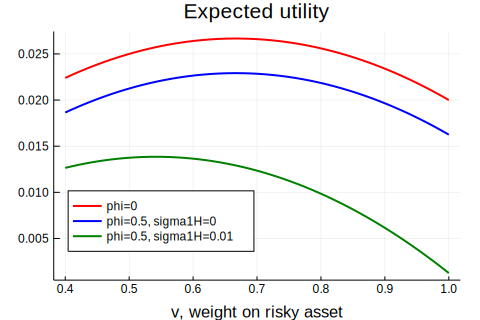

In [5]:
println("Notice: with σ1H=0, the choice of v is not affected by ϕ")

p1 = plot(v,EUM[:,1],color=:red,linewidth=2,label="phi=0")
plot!(v,EUM[:,2],color=:blue,linewidth=2,label="phi=0.5, sigma1H=0 ")
plot!(v,EUM[:,3],color=:green,linewidth=2,label="phi=0.5, sigma1H=0.01    ")
plot!(legend=:bottomleft)
title!("Expected utility")
xlabel!("v, weight on risky asset")

# Asset Pricing Implications of Background Risk I: CAPM

Recall:

The beta from CAPM regression: $R_{i}^{e}=\alpha_{i}+\beta_{i}R_{m}^{e}+\varepsilon_{i}$ is 

$\beta_{i}=\frac{\sigma_{im}}{\sigma_{mm}}$

Correct pricing expression:

$\mu_{i}^{e} =\tilde{\beta}_{i}\mu_{m}^{e}$, where 
$\tilde{\beta}_{i}  =\frac{\sigma_{im}+\phi\left(  \sigma_{iH}-\sigma_{im}\right)  }{\sigma_{mm}+\phi\left(\sigma_{mH}-\sigma_{mm}\right)  }$

The $\alpha_{i}$ in the CAPM regression can be shown to be
$\alpha_{i}=(\tilde{\beta}_{i}-\beta_{i})\mu_{m}^{e}$

In [6]:
βtilde(σim,ϕ,σiH,σmm,σmH) = (σim + ϕ*(σiH-σim))/(σmm + ϕ*(σmH-σmm))     #a function giving βtilde as above

βtilde (generic function with 1 method)

In [7]:
σim = 0.8                                             #parameter values for the calculations below
σmm = 1
σiH = -0.5
σmH = 0.5
μem = 0.08

β = σim/σmm
βtildeA = βtilde(σim,0,σiH,σmm,σmH)                   #case A, βtilde when ϕ=0
βtildeB = βtilde(σim,0.3,σiH,σmm,σmH)                 #case B, βtilde when ϕ=0.3, otherwise the same 

println("betas: CAPM and the ones to use in finding μᵢ")
printmat([β βtildeA βtildeB])

println("Expected excess return according to βtilde (μᵉ)")
printmat([βtildeA*μem βtildeB*μem])  

println("alphas in CAPM regressions: no background risk, background risk case A, case B")
αA = (βtildeA - β)*μem
αB = (βtildeB - β)*μem
printmat([0 αA αB])

betas: CAPM and the ones to use in finding μᵢ
     0.800     0.800     0.482

Expected excess return according to βtilde (μᵉ)
     0.064     0.039

alphas in CAPM regressions: no background risk, background risk case A, case B
     0.000     0.000    -0.025



# Asset Pricing Implications of Background Risk II: Multi-Factor Model (extra)

In [8]:
σHH = 2
μeH = 0.089

Σ = [σmm σmH;                   #covariance matrix of [Rm,RH]
     σmH σHH]
SH = [σim;σiH]                  #Cov(Ri,Rm) and Cov(Ri,RH)

βmult = inv(Σ)*SH               #coeffs in Ri = βmult'[Rm;RH]
printlnPs("The multiple regression coefficients: ",βmult)

μei = βmult'*[μem;μeH]
printlnPs("\nμᵉ according to 2-factor model (cf. previous results) ",μei)

The multiple regression coefficients:      1.057    -0.514

μᵉ according to 2-factor model (cf. previous results)      0.039


# Empirical Test of a 3-Factor Model: Loading Data

In [9]:
x    = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = x[:,2]                #market excess return
RSMB = x[:,3]                #small minus big firms
RHML = x[:,4]                #high minus low book-to-market ratio
Rf   = x[:,5]                #interest rate


x  = readdlm("Data/FF25Ps.csv",',') #no header line: x is matrix
R  = x[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                        #excess returns for the 25 FF portfolios
Re = Re[:,[1,7,13,19,25]]           #use just 5 assets to make the printing easier 

(T,n) = size(Re)                 #no. obs and  no. test assets

(388, 5)

## OLS Estimation and Testing α = 0

Recall: estimate $(\alpha_{i},b_{i})$ in the factor model

$R_{it}^{e}  =\alpha_{i}+b_{i}'f_{t} + \varepsilon_{it}$

Test if $\alpha_{i}=0$

Under the Gauss-Markov assumptions, $\textrm{Cov}([\alpha_{i},b_{i}]) = (X'X)^{-1}\textrm{Var}(\varepsilon_{it})$,
where row $t$ of $X$ contains $[1, f_{t}]$. Use element [1,1] of the covariance matrix as the variance of the $\alpha_i$ estimate

In [10]:
x   = [ones(T) Rme RSMB RHML]         #regressors
Σ_1 = inv(x'x)

α     = fill(NaN,n)
tstat = fill(NaN,n)
for i = 1:n                              #loop over the different test assets
    local b_i, residual, Covb
    b_i       = x\Re[:,i]                #OLS
    residual  = Re[:,i] - x*b_i
    α[i]      = b_i[1]
    Covb      = Σ_1*var(residual)   
    tstat[i] = (α[i]-0)/sqrt(Covb[1,1])
end    
println("\nOLS intercepts and t-stats, regressing Re on constant and 3 factors")
printmat([α tstat])


OLS intercepts and t-stats, regressing Re on constant and 3 factors
    -0.513    -2.306
    -0.006    -0.066
     0.030     0.328
    -0.020    -0.206
    -0.015    -0.133

